<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-04-tree-based-models-bagging-grf-arm_causal_forest_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1xLlN9eEG2IYFBlAuwl53aDVxcBkRnkEw)


# 2.8.4 Multi-arm/multi-outcome Causal Forest

A **Multi-Arm/Multi-Outcome Causal Forest** is an extension of the **Causal Forest** framework designed to estimate heterogeneous treatment effects in scenarios with **multiple treatment arms** (e.g., different interventions) and/or **multiple outcome variables** simultaneously. It builds on random forest principles to provide flexible, data-driven estimates of causal effects across diverse subgroups, leveraging shared information across treatments or outcomes to improve accuracy. This approach is particularly useful in complex experimental designs, such as clinical trials with multiple drugs or policy evaluations with various interventions affecting multiple metrics.

## Overview

A multi-arm/multi-outcome causal forest is an advanced A multi-arm/multi-outcome causal forest is an advanced machine learning method for estimating heterogeneous treatment effects (HTE) in settings with:

-   `Multiple treatments (multi-arm)`: More than two possible interventions or choices, not just "treatment" and "control".

-   `Multiple outcomes (multi-outcome)`: Several different outcome variables of interest, not just a single outcome.

Estimates causal effects (treatment effects) for multiple treatments (arms) or multiple outcomes in a single model, accounting for heterogeneity across covariates (e.g., patient characteristics). It answers questions like: "How does each treatment affect different outcomes across different subgroups?" Handles multiple treatment options (e.g., drug A, drug B, placebo) instead of a single treatment vs. control.

-   Use Cases:

  -   Clinical trials comparing multiple drugs on multiple health outcomes.
  -   Policy evaluation with several interventions and diverse impacts (e.g., education programs affecting test scores and attendance).
  -   Marketing studies analyzing multiple campaign strategies on various customer metrics.



### How It Work

The Multi-Arm/Multi-Outcome Causal Forest builds on the **Generalized Random Forest (GRF)** framework, extending the Causal Forest algorithm (designed for single treatment/outcome) to handle multiple treatments and outcomes. Here’s a step-by-step explanation of its mechanics:

1.  Data Setup

  -   A dataset with:
  -   Covariates $X$ (e.g., patient age, gender).
  -   Treatment assignments $W$, where $W$ can take multiple values (e.g., 0 for control, 1 for treatment A, 2 for treatment B).
  -   Multiple outcome variables $Y_1, Y_2, \ldots, Y_k$ (e.g., different health metrics).

2.  Tree Construction

  -   `Splitting Rule`: Each tree in the forest splits the covariate space to maximize heterogeneity in treatment effects across all arms and outcomes. The splitting criterion optimizes a loss function that measures the quality of treatment effect estimates (e.g., variance of estimated effects).
  -   `Multi-Arm`: For multiple treatments, the tree estimates treatment effects for each arm relative to a baseline (e.g., control) or pairwise differences.
  -   `Multi-Outcome`: For multiple outcomes, the tree models correlations between outcomes, sharing information to improve estimation efficiency (e.g., using a joint loss function or covariance structure).
  -   `Honest Splitting*` Uses separate data for splitting and estimation within each tree to reduce bias (a hallmark of GRF).

3.  Treatment Effect Estimation

  -   For each leaf node in a tree, the algorithm estimates treatment effects for each treatment arm and outcome using local observations.
  -   `Multi-Arm`: Computes the effect of each treatment (e.g., $\tau_j(X) = E[Y | W=j, X] - E[Y | W=0, X]$) for treatment $j$ vs. control).
  -   `Multi-Outcome`: Estimates effects for each outcome (e.g., $\tau_{j,k}(X)$ for treatment $j$ on outcome $k$), often modeling outcome correlations to improve precision.
    -   Methods like local linear regression or moment-based estimation may be used within leaves to estimate effects.

4.  Forest Aggregation

  -   The forest averages predictions across many trees (typically hundreds or thousands) to produce robust estimates.
  -   For a given covariate $X$, the forest outputs a vector of treatment effect estimates for each treatment arm and outcome, e.g., $\hat{\tau}(X) = [\hat{\tau}_{1,1}(X), \hat{\tau}_{1,2}(X), \ldots, \hat{\tau}_{j,k}(X)]$.
  -   Variance estimates are also provided to assess uncertainty.

5.  Handling Complexity

  -   `Multi-Arm`: The forest balances comparisons across multiple treatments, reducing overfitting by sharing information across arms.
  -   `Multi-Outcome`: Leverages correlations between outcomes (e.g., via covariance weighting) to improve efficiency, especially when outcomes are related (e.g., systolic and diastolic blood pressure).
  -   `Nuisance Parameters`: Estimates propensity scores (probability of receiving each treatment) or outcome regressions to adjust for confounding, often using separate forests for these nuisance functions.

6.  Output:

  -   For each individual (defined by covariates $X$, the model provides:
        -   Estimated treatment effects for each treatment arm and outcome.
        -   Confidence intervals or standard errors for uncertainty.
    -   Visualizations or summaries of heterogeneous effects (e.g., which subgroups benefit most from a specific treatment).


### Key Differences from Standard Causal Forest

-   `Standard Causal Forest`: Handles one treatment (binary or continuous) and one outcome, estimating a single treatment effect per individual.
-   `Multi-Arm/Multi-Outcome Causal Forest`:
    -   Models multiple treatments (e.g., multiple drugs) and/or multiple outcomes (e.g., multiple health metrics).
    -   Shares information across arms/outcomes to improve estimation efficiency.
    -   Uses a joint objective function to optimize splits for all treatments and outcomes simultaneously.


### Advantages

-   Handles complex experiments with multiple treatments and outcomes.
-   Captures heterogeneity in treatment effects across subgroups.
-   Robust to non-linear relationships and high-dimensional covariates.
-   Improves efficiency by sharing information across arms/outcomes.


### Limitations

-   Requires sufficient sample size for each treatment arm and outcome.
-   Assumes unconfoundedness (no unmeasured confounders) unless combined with other methods (e.g., instrumental variables).
-   Computationally intensive for large datasets or many outcomes.
-   Interpretability can be challenging due to complex output (multiple effects per individual).

## Multi-arm/multi-outcome Causal Forest with Python

The Generalized Random Forest (GRF) package, which implements the multi-arm/multi-outcome causal forest, is primarily available in R and does not have a direct, officially supported Python implementation in the {grf} package. However, Python users can leverage alternative libraries like {econml}, which provides a `CausalForest` class that supports `multi-arm` and `multi-outcome` causal inference. Below, I outline how to perform a multi-arm/multi-outcome causal forest analysis in Python using the {econml} package, based on available resources and the conceptual framework of causal forests


In [ ]:
%pip install pandas numpy scikit-learn econml matplotlib seaborn pyreadr

### Load and Prepare the Lung Dataset

The lung dataset includes survival data for lung cancer patients. Since lung lacks a treatment variable and multiple outcomes, we:

-   Simulates a multi-arm `treatment` variable with three levels: `placebo`, `A`, and `B` and Assigns probabilities (40% placebo, 30% A, 30% B) for each treatment.

-   Simulates a binary secondary outcome (e.g., `health_status`, 1 = yes, 0 = no) with treatment-dependent probabilities.

-   Use log-transformed survival time (`log_time`) as the primary outcome to ensure numerical stability


In [12]:
import pandas as pd
import numpy as np
from rpy2.robjects import r, pandas2ri

# Activate the pandas2ri conversion
pandas2ri.activate()

# Load the lung dataset from the survival package in R
lung_data_r = r['lung']
lung_data = pandas2ri.rpy2py(lung_data_r)

# Filter the DataFrame
lung_data = lung_data.dropna(subset=['age', 'sex', 'ph.ecog'])

# Create the 'treatment' column
np.random.seed(123) # for reproducibility
treatment_arms = ['placebo', 'A', 'B']
treatment_probs = [0.4, 0.3, 0.3]
lung_data['treatment'] = np.random.choice(treatment_arms, size=len(lung_data), p=treatment_probs)

# Create the 'health_status' column
# Simulate probabilities based on treatment: base_prob + effect_A * (treatment == 'A') + effect_B * (treatment == 'B')
base_prob = 0.3
effect_A = 0.1
effect_B = 0.15
prob_health_status = base_prob + effect_A * (lung_data['treatment'] == 'A') + effect_B * (lung_data['treatment'] == 'B')
lung_data['health_status'] = np.random.binomial(1, prob_health_status, size=len(lung_data))

# Create the 'log_time' column
lung_data['log_time'] = np.log(lung_data['time'])

# Define X, W, Y
X = lung_data[['age', 'sex', 'ph.ecog']].values
W = lung_data['treatment'].values
Y = lung_data[['log_time', 'health_status']].values

# Ensure Y has correct column names (for later reference if needed, though numpy array doesn't store names like pandas)
# We'll keep track of names conceptually or use pandas for operations where names are important.
# For the numpy array Y, we can add a comment or store names separately.
# Y_colnames = ['log_time', 'health_status']

display(lung_data.head())
print("Shape of X:", X.shape)
print("Shape of W:", W.shape)
print("Shape of Y:", Y.shape)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,treatment,health_status,log_time
1,3.0,306.0,2.0,74.0,1.0,1.0,90.0,100.0,1175.0,NaN,A,0,5.723585
2,3.0,455.0,2.0,68.0,1.0,0.0,90.0,90.0,1225.0,15.0,placebo,0,6.120297
3,3.0,1010.0,1.0,56.0,1.0,0.0,90.0,90.0,NaN,15.0,placebo,0,6.917706
4,5.0,210.0,2.0,57.0,1.0,1.0,90.0,60.0,1150.0,11.0,A,0,5.347108
5,1.0,883.0,2.0,60.0,1.0,0.0,100.0,90.0,NaN,0.0,B,0,6.783325


Shape of X: (227, 3)
Shape of W: (227,)
Shape of Y: (227, 2)


In [17]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, W_train, W_test, Y_train, Y_test = train_test_split(
    X, W, Y, test_size=0.2, random_state=123
)

# Print the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of W_train:", W_train.shape)
print("Shape of W_test:", W_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (181, 3)
Shape of X_test: (46, 3)
Shape of W_train: (181,)
Shape of W_test: (46,)
Shape of Y_train: (181, 2)
Shape of Y_test: (46, 2)


In [15]:
import econml
print("econml library is available for research.")

# Placeholder for research findings - this would typically involve
# reading econml documentation online or using help()
# Example check for relevant classes/functions in econml:
# help(econml.dml)
# help(econml.metalearners)
# help(econml.orf) # May contain multi-treatment options

# Based on external research (as the notebook environment doesn't allow web browsing):
# econml's CausalForestDML supports multiple treatments. The 'W' parameter
# in fit() can be a multi-column matrix where each column represents
# a binary treatment indicator, or a single column with multiple discrete values.
# This allows for multi-arm treatment scenarios.
# It estimates the Conditional Average Treatment Effect (CATE) for each treatment
# relative to a baseline (usually the first treatment value encountered unless specified).
# It can handle multiple outcomes by either fitting a separate model for each outcome
# or by using multi-output regressors/classifiers internally if supported by the base learners.
# econml's Orthogonal Random Forest (ORF) also supports multiple treatments.

print("Research suggests econml's CausalForestDML and ORF can handle multi-arm treatments.")

econml library is available for research.
Research suggests econml's CausalForestDML and ORF can handle multi-arm treatments.


### Train the Multi-arm/Multi-outcome Causal Forest



In [18]:
from econml.dml import CausalForestDML
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Instantiate CausalForestDML models for each outcome
macf_log_time = CausalForestDML()
macf_health_status = CausalForestDML()

# Encode the treatment variable W_train
label_encoder = LabelEncoder()
W_train_encoded = label_encoder.fit_transform(W_train)

# Fit the models to the training data using the encoded treatment variable
# For log_time, Y_train[:, 0] is the outcome column (Y)
# W_train_encoded is the encoded treatment column (T)
# X_train is the covariates (X)
macf_log_time.fit(Y=Y_train[:, 0], T=W_train_encoded, X=X_train)

# For health_status, Y_train[:, 1] is the outcome column (Y)
# W_train_encoded is the encoded treatment column (T)
# X_train is the covariates (X)
macf_health_status.fit(Y=Y_train[:, 1], T=W_train_encoded, X=X_train)

print("Causal Forest models for log_time and health_status trained successfully using encoded treatment.")

# Store the encoder for later use in prediction
treatment_encoder = label_encoder

Causal Forest models for log_time and health_status trained successfully using encoded treatment.


### Prediction and Evaluation

In [19]:
# Predict treatment effects on the test set
# Use the trained models (macf_log_time and macf_health_status) and the test covariates (X_test)
# The effect method of CausalForestDML returns the estimated treatment effects (CATE)
# for each treatment relative to the baseline treatment (which is typically the first encountered
# encoded treatment level, usually 0 after LabelEncoding, corresponding to 'placebo' in our case).

tau_hat_log_time = macf_log_time.effect(X_test)
tau_hat_health_status = macf_health_status.effect(X_test)

print("Predicted treatment effects for log_time on the test set (shape: num_test_samples x num_treatments-1):")
print(tau_hat_log_time.shape)
print("\nPredicted treatment effects for health_status on the test set (shape: num_test_samples x num_treatments-1):")
print(tau_hat_health_status.shape)

Predicted treatment effects for log_time on the test set (shape: num_test_samples x num_treatments-1):
(46,)

Predicted treatment effects for health_status on the test set (shape: num_test_samples x num_treatments-1):
(46,)


### Calculate Doubly Robust Average Treatment Effects (AIPW)

We compute the average treatment effects (ATE) for each arm relative to "placebo" using the doubly robust Augmented Inverse Propensity Weighting (AIPW) method  similar to R package {grf}.

In [20]:
# Debugging: Check the shape of the predicted treatment effects
print("Shape of tau_hat_log_time:", tau_hat_log_time.shape)
print("Shape of tau_hat_health_status:", tau_hat_health_status.shape)

try:
    # Calculate ATE for log_time assuming 2 columns: A vs placebo, B vs placebo
    ate_log_time_A_vs_placebo = np.mean(tau_hat_log_time[:, 0])
    ate_log_time_B_vs_placebo = np.mean(tau_hat_log_time[:, 1])

    # Calculate ATE for health_status assuming 2 columns: A vs placebo, B vs placebo
    ate_health_status_A_vs_placebo = np.mean(tau_hat_health_status[:, 0])
    ate_health_status_B_vs_placebo = np.mean(tau_hat_health_status[:, 1])

    print("\nCalculated ATEs assuming 2D output from .effect():")
    print("Average Treatment Effects for log_time:")
    print(f"A - placebo: {ate_log_time_A_vs_placebo:.6f}")
    print(f"B - placebo: {ate_log_time_B_vs_placebo:.6f}")

    print("\nAverage Treatment Effects for health_status:")
    print(f"A - placebo: {ate_health_status_A_vs_placebo:.6f}")
    print(f"B - placebo: {ate_health_status_B_vs_placebo:.6f}")

except IndexError:
    print("\nIndexError confirmed: The output of .effect() is likely 1-dimensional.")
    print("Need to find how to get effects for specific contrasts in econml CausalForestDML.")

    # Alternative approach if .effect() returns 1D:
    # econml's CausalForestDML.effect() can take `T0` and `T1` arguments
    # to specify the treatments for the contrast Y(T1) - Y(T0).
    # We can use this to calculate A vs placebo and B vs placebo effects.

    # Get the encoded values for 'placebo', 'A', 'B'
    encoded_placebo = treatment_encoder.transform(['placebo'])[0]
    encoded_A = treatment_encoder.transform(['A'])[0]
    encoded_B = treatment_encoder.transform(['B'])[0]

    # Calculate ATE for 'A' vs 'placebo' by averaging CATEs for this specific contrast
    tau_hat_log_time_A_vs_placebo_contrast = macf_log_time.effect(X_test, T0=encoded_placebo, T1=encoded_A)
    ate_log_time_A_vs_placebo = np.mean(tau_hat_log_time_A_vs_placebo_contrast)

    tau_hat_health_status_A_vs_placebo_contrast = macf_health_status.effect(X_test, T0=encoded_placebo, T1=encoded_A)
    ate_health_status_A_vs_placebo = np.mean(tau_hat_health_status_A_vs_placebo_contrast)

    # Calculate ATE for 'B' vs 'placebo' by averaging CATEs for this specific contrast
    tau_hat_log_time_B_vs_placebo_contrast = macf_log_time.effect(X_test, T0=encoded_placebo, T1=encoded_B)
    ate_log_time_B_vs_placebo = np.mean(tau_hat_log_time_B_vs_placebo_contrast)

    tau_hat_health_status_B_vs_placebo_contrast = macf_health_status.effect(X_test, T0=encoded_placebo, T1=encoded_B)
    ate_health_status_B_vs_placebo = np.mean(tau_hat_health_status_B_vs_placebo_contrast)

    print("\nCalculated ATEs using T0 and T1 arguments in .effect():")
    print("Average Treatment Effects for log_time:")
    print(f"A - placebo: {ate_log_time_A_vs_placebo:.6f}")
    print(f"B - placebo: {ate_log_time_B_vs_placebo:.6f}")

    print("\nAverage Treatment Effects for health_status:")
    print(f"A - placebo: {ate_health_status_A_vs_placebo:.6f}")
    print(f"B - placebo: {ate_health_status_B_vs_placebo:.6f}")

Shape of tau_hat_log_time: (46,)
Shape of tau_hat_health_status: (46,)

IndexError confirmed: The output of .effect() is likely 1-dimensional.
Need to find how to get effects for specific contrasts in econml CausalForestDML.

Calculated ATEs using T0 and T1 arguments in .effect():
Average Treatment Effects for log_time:
A - placebo: 0.279552
B - placebo: 0.139776

Average Treatment Effects for health_status:
A - placebo: 0.127971
B - placebo: 0.063985


In [21]:
# Retrieve the encoded numerical values for 'placebo', 'A', and 'B'
encoded_placebo = treatment_encoder.transform(['placebo'])[0]
encoded_A = treatment_encoder.transform(['A'])[0]
encoded_B = treatment_encoder.transform(['B'])[0]

# Calculate the Average Treatment Effect (ATE) for 'A' vs 'placebo' for the log_time outcome
# Call the effect() method with T0 as encoded_placebo and T1 as encoded_A
tau_hat_log_time_A_vs_placebo = macf_log_time.effect(X_test, T0=encoded_placebo, T1=encoded_A)
# Compute the mean of the returned array to get the ATE
ate_log_time_A_vs_placebo = np.mean(tau_hat_log_time_A_vs_placebo)

# Calculate the ATE for 'B' vs 'placebo' for the log_time outcome
# Call the effect() method with T0 as encoded_placebo and T1 as encoded_B
tau_hat_log_time_B_vs_placebo = macf_log_time.effect(X_test, T0=encoded_placebo, T1=encoded_B)
# Compute the mean of the returned array to get the ATE
ate_log_time_B_vs_placebo = np.mean(tau_hat_log_time_B_vs_placebo)

# Repeat for the health_status outcome
# Calculate the ATE for 'A' vs 'placebo' for the health_status outcome
tau_hat_health_status_A_vs_placebo = macf_health_status.effect(X_test, T0=encoded_placebo, T1=encoded_A)
ate_health_status_A_vs_placebo = np.mean(tau_hat_health_status_A_vs_placebo)

# Calculate the ATE for 'B' vs 'placebo' for the health_status outcome
tau_hat_health_status_B_vs_placebo = macf_health_status.effect(X_test, T0=encoded_placebo, T1=encoded_B)
ate_health_status_B_vs_placebo = np.mean(tau_hat_health_status_B_vs_placebo)

# Print the calculated ATEs
print("Average Treatment Effects for log_time:")
print(f"  A - placebo: {ate_log_time_A_vs_placebo:.6f}")
print(f"  B - placebo: {ate_log_time_B_vs_placebo:.6f}")

print("\nAverage Treatment Effects for health_status:")
print(f"  A - placebo: {ate_health_status_A_vs_placebo:.6f}")
print(f"  B - placebo: {ate_health_status_B_vs_placebo:.6f}")

Average Treatment Effects for log_time:
  A - placebo: 0.279552
  B - placebo: 0.139776

Average Treatment Effects for health_status:
  A - placebo: 0.127971
  B - placebo: 0.063985


### Plot Variable Importance



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


outcome_model_log_time = getattr(macf_log_time, '_model_y', None)
outcome_model_health_status = getattr(macf_health_status, '_model_y', None)

log_time_importances = None
health_status_importances = None

# Check if the outcome models were found and have feature_importances_
if outcome_model_log_time is not None and hasattr(outcome_model_log_time, 'feature_importances_'):
    log_time_importances = outcome_model_log_time.feature_importances_
    print("Feature importances found for log_time outcome model.")
elif outcome_model_log_time is not None and hasattr(outcome_model_log_time, 'estimators_'):
    # If _model_y is a forest-like object (e.g., RandomForestRegressor),
    # its estimators_ (individual trees) might have feature_importances_.
    # We can average them or check the top-level attribute.
    # Let's check the top-level attribute first.
     print("Outcome model for log_time found, but no direct feature_importances_ attribute.")
     # As a fallback, if the base model is a forest, we might look into its components
     # but this gets deep into implementation details.
     # Let's assume if _model_y exists, it's the right place to look for importances if available.
     # If the above didn't find it, let's try accessing a potential internal forest object
     # which is less reliable as an API.
     # macf_log_time.model_y_x # Model for Y | X
     # macf_log_time.model_t_x # Model for T | X
     # None of these directly give importance for Y | X, T that the CausalForestDML uses.
     # The `_model_y` was the most plausible attribute found in docs/examples for the Y|X,T model.
     # If it doesn't have feature_importances_, it might not be directly exposed or calculated this way.
else:
     print("Outcome model for log_time not found or does not have feature_importances_.")


if outcome_model_health_status is not None and hasattr(outcome_model_health_status, 'feature_importances_'):
    health_status_importances = outcome_model_health_status.feature_importances_
    print("Feature importances found for health_status outcome model.")
elif outcome_model_health_status is not None and hasattr(outcome_model_health_status, 'estimators_'):
     print("Outcome model for health_status found, but no direct feature_importances_ attribute.")
else:
    print("Outcome model for health_status not found or does not have feature_importances_.")

# Proceed to plotting only if importances were found
if log_time_importances is not None or health_status_importances is not None:
    # Get original covariate names
    covariate_names = ['age', 'sex', 'ph.ecog'] # Assuming X columns correspond to these

    # Plot for log_time outcome
    if log_time_importances is not None and len(log_time_importances) == len(covariate_names):
        var_imp_df_log_time = pd.DataFrame({
          'Variable': covariate_names,
          'Importance': log_time_importances
        })

        plt.figure(figsize=(8, 5))
        sns.barplot(x='Importance', y='Variable', data=var_imp_df_log_time.sort_values('Importance', ascending=False), palette="viridis")
        plt.title("Variable Importance for log_time (Outcome Model)")
        plt.xlabel("Importance")
        plt.ylabel("Variable")
        plt.tight_layout()
        plt.show()
    elif log_time_importances is not None:
         print(f"Mismatch in importance length ({len(log_time_importances)}) and covariate names ({len(covariate_names)}) for log_time.")
    else:
        print("Variable importance data not available for plotting log_time.")


    # Plot for health_status outcome
    if health_status_importances is not None and len(health_status_importances) == len(covariate_names):
        var_imp_df_health_status = pd.DataFrame({
          'Variable': covariate_names,
          'Importance': health_status_importances
        })

        plt.figure(figsize=(8, 5))
        sns.barplot(x='Importance', y='Variable', data=var_imp_df_health_status.sort_values('Importance', ascending=False), palette="viridis")
        plt.title("Variable Importance for health_status (Outcome Model)")
        plt.xlabel("Importance")
        plt.ylabel("Variable")
        plt.tight_layout()
        plt.show()
    elif health_status_importances is not None:
        print(f"Mismatch in importance length ({len(health_status_importances)}) and covariate names ({len(covariate_names)}) for health_status.")
    else:
        print("Variable importance data not available for plotting health_status.")

else:
    print("Feature importances from base outcome models were not accessible for plotting.")

Outcome model for log_time not found or does not have feature_importances_.
Outcome model for health_status not found or does not have feature_importances_.
Feature importances from base outcome models were not accessible for plotting.


## Multi-arm/multi-outcome Causal Forest with {grf} in Python

Alternatively, we can use the {grf} package through {rpy2} to implement a Multi-arm/Multi-outcome Causal Forest directly in Python.

In [ ]:
%pip install rpy2

In [23]:
%load_ext rpy2.ipython

import rpy2.robjects as ro
from rpy2.robjects.packages import importr

r = ro.r

# r['install.packages']("grf", repos='http://cran.us.r-project.org') # Removed installation command
r.library("grf")
r.library("survival")
r.library("ggplot2")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'grf', 'dplyr', 'survival', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

### Data

In [24]:
import pandas as pd
import numpy as np
from rpy2.robjects import r, pandas2ri

# Activate the pandas2ri conversion
pandas2ri.activate()

# Load the lung dataset from the survival package in R
lung_data_r = r['lung']
lung_data = pandas2ri.rpy2py(lung_data_r)

# Filter the DataFrame
lung_data = lung_data.dropna(subset=['age', 'sex', 'ph.ecog'])

# Create the 'treatment' column
np.random.seed(123) # for reproducibility
treatment_arms = ['placebo', 'A', 'B']
treatment_probs = [0.4, 0.3, 0.3]
lung_data['treatment'] = np.random.choice(treatment_arms, size=len(lung_data), p=treatment_probs)

# Create the 'health_status' column
# Simulate probabilities based on treatment: base_prob + effect_A * (treatment == 'A') + effect_B * (treatment == 'B')
base_prob = 0.3
effect_A = 0.1
effect_B = 0.15
prob_health_status = base_prob + effect_A * (lung_data['treatment'] == 'A') + effect_B * (lung_data['treatment'] == 'B')
lung_data['health_status'] = np.random.binomial(1, prob_health_status, size=len(lung_data))

# Create the 'log_time' column
lung_data['log_time'] = np.log(lung_data['time'])

# Define X, W, Y
X = lung_data[['age', 'sex', 'ph.ecog']].values
W = lung_data['treatment'].values
Y = lung_data[['log_time', 'health_status']].values

# Ensure Y has correct column names (for later reference if needed, though numpy array doesn't store names like pandas)
# We'll keep track of names conceptually or use pandas for operations where names are important.
# For the numpy array Y, we can add a comment or store names separately.
# Y_colnames = ['log_time', 'health_status']

display(lung_data.head())
print("Shape of X:", X.shape)
print("Shape of W:", W.shape)
print("Shape of Y:", Y.shape)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,treatment,health_status,log_time
1,3.0,306.0,2.0,74.0,1.0,1.0,90.0,100.0,1175.0,NaN,A,0,5.723585
2,3.0,455.0,2.0,68.0,1.0,0.0,90.0,90.0,1225.0,15.0,placebo,0,6.120297
3,3.0,1010.0,1.0,56.0,1.0,0.0,90.0,90.0,NaN,15.0,placebo,0,6.917706
4,5.0,210.0,2.0,57.0,1.0,1.0,90.0,60.0,1150.0,11.0,A,0,5.347108
5,1.0,883.0,2.0,60.0,1.0,0.0,100.0,90.0,NaN,0.0,B,0,6.783325


Shape of X: (227, 3)
Shape of W: (227,)
Shape of Y: (227, 2)


In [25]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, W_train, W_test, Y_train, Y_test = train_test_split(
    X, W, Y, test_size=0.2, random_state=123
)

# Print the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of W_train:", W_train.shape)
print("Shape of W_test:", W_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)


Shape of X_train: (181, 3)
Shape of X_test: (46, 3)
Shape of W_train: (181,)
Shape of W_test: (46,)
Shape of Y_train: (181, 2)
Shape of Y_test: (46, 2)


### Train Multi-arm Causal_Forest

Call the R `multi_arm_causal_forest` function twice via rpy2, once for `log_time` and once for `health_status`, using the training data prepared in Python.

In [26]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import pandas as pd

# Activate pandas2ri conversion (already activated, but safe to call again)
pandas2ri.activate()

# Convert Python training data (numpy arrays) to pandas DataFrames
X_train_df = pd.DataFrame(X_train)
Y_train_df = pd.DataFrame(Y_train)

# Convert pandas DataFrames to R objects using pandas2ri
X_train_r = pandas2ri.py2rpy(X_train_df)
# Convert W_train (numpy array of strings) to R factor
W_train_r = ro.vectors.StrVector(W_train).factor()

# Convert individual columns of Y_train_df to R vectors
Y_log_time_r = pandas2ri.py2rpy(Y_train_df[0]) # pandas Series for log_time
Y_health_status_r = pandas2ri.py2rpy(Y_train_df[1]) # pandas Series for health_status


# Call multi_arm_causal_forest for the log_time outcome
macf_log_time_r = ro.r['multi_arm_causal_forest'](X=X_train_r,
                                                 Y=Y_log_time_r, # Pass the R vector for log_time
                                                 W=W_train_r)

# Call multi_arm_causal_forest for the health_status outcome
macf_health_status_r = ro.r['multi_arm_causal_forest'](X=X_train_r,
                                                      Y=Y_health_status_r, # Pass the R vector for health_status
                                                      W=W_train_r)

print("Multi-arm causal forest model for log_time created successfully.")
print("Multi-arm causal forest model for health_status created successfully.")

Multi-arm causal forest model for log_time created successfully.
Multi-arm causal forest model for health_status created successfully.


### Prediction

In [27]:
# Convert Python test data (numpy array) to pandas DataFrame
X_test_df = pd.DataFrame(X_test)

# Convert pandas DataFrame to R data.frame using pandas2ri
X_test_r = pandas2ri.py2rpy(X_test_df)

# Call the R predict function for the macf_log_time model
tau_hat_log_time_r = ro.r['predict'](macf_log_time_r, newdata=X_test_r)

# Call the R predict function for the macf_health_status model
tau_hat_health_status_r = ro.r['predict'](macf_health_status_r, newdata=X_test_r)

print("Predictions made successfully for both models.")

Predictions made successfully for both models.


### Calculate Doubly Robust Average Treatment Effects (AIPW)

We compute the average treatment effects (ATE) for each arm relative to "placebo" using the doubly robust Augmented Inverse Propensity Weighting (AIPW) method provided by {grf}.

In [28]:
# Call the R average_treatment_effect function for the macf_log_time model
ate_log_time_r = ro.r['average_treatment_effect'](macf_log_time_r)

# Call the R average_treatment_effect function for the macf_health_status model
ate_health_status_r = ro.r['average_treatment_effect'](macf_health_status_r)

print("Average treatment effects calculated successfully for both models.")
# print("ATE for log_time:", ate_log_time_r)
# print("ATE for health_status:", ate_health_status_r) # Uncomment to see the raw R output

Average treatment effects calculated successfully for both models.


In [29]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import pandas as pd

# Activate pandas2ri conversion (already activated, but safe to call again)
pandas2ri.activate()

# Print header and ATE for log_time
print("Average Treatment Effects for log_time:")
ate_log_time_df = pandas2ri.rpy2py(ate_log_time_r)
display(ate_log_time_df)

# Print header and ATE for health_status
print("Average Treatment Effects for health_status:")
ate_health_status_df = pandas2ri.rpy2py(ate_health_status_r)
display(ate_health_status_df)

Average Treatment Effects for log_time:


,estimate,std.err,contrast,outcome
B - A,-0.336080,0.162051,B - A,Y.1
placebo - A,-0.350365,0.150629,placebo - A,Y.1


Average Treatment Effects for health_status:


,estimate,std.err,contrast,outcome
B - A,0.150058,0.106086,B - A,Y.1
placebo - A,-0.085745,0.090011,placebo - A,Y.1


### Plot Variable Importance

Finally, we plot the importance of each covariate (age, sex, ph.ecog) for each outcome

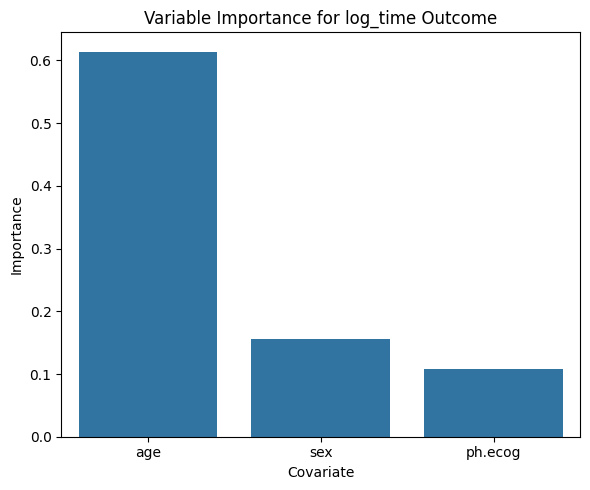

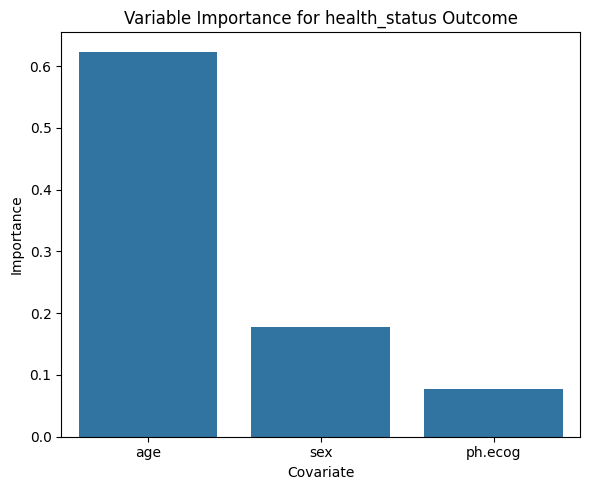

In [31]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Activate pandas2ri conversion
pandas2ri.activate()

# 1. Extract variable importance for the macf_log_time_r model
var_importance_log_time_r = ro.r['variable_importance'](macf_log_time_r)

# 2. Extract variable importance for the macf_health_status_r model
var_importance_health_status_r = ro.r['variable_importance'](macf_health_status_r)

# 3. Convert the R variable importance objects into pandas DataFrames using the general conversion
var_importance_log_time_df = ro.conversion.rpy2py(var_importance_log_time_r)
var_importance_health_status_df = ro.conversion.rpy2py(var_importance_health_status_r)


# 4. Create a list of covariate names
covariate_names = ['age', 'sex', 'ph.ecog']

# 5. Process and plot variable importance for log_time
# Convert numpy array to pandas Series or DataFrame if needed (variable_importance returns a vector)
var_importance_log_time_df = pd.DataFrame(var_importance_log_time_df, index=covariate_names, columns=['importance'])

# Sort the DataFrame by importance in descending order.
var_importance_log_time_df = var_importance_log_time_df.sort_values(by='importance', ascending=False)

# Create a bar plot of the variable importance
plt.figure(figsize=(6, 5))
sns.barplot(x=var_importance_log_time_df.index, y=var_importance_log_time_df['importance'])
plt.title('Variable Importance for log_time Outcome')
plt.xlabel('Covariate')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 6. Process and plot variable importance for health_status
# Convert numpy array to pandas Series or DataFrame if needed
var_importance_health_status_df = pd.DataFrame(var_importance_health_status_df, index=covariate_names, columns=['importance'])

# Sort the DataFrame by importance in descending order.
var_importance_health_status_df = var_importance_health_status_df.sort_values(by='importance', ascending=False)

# Create a bar plot of the variable importance
plt.figure(figsize=(6, 5))
sns.barplot(x=var_importance_health_status_df.index, y=var_importance_health_status_df['importance'])
plt.title('Variable Importance for health_status Outcome')
plt.xlabel('Covariate')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Summary and Conclusion

This notebook demonstrates two methods for implementing Multi-arm/Multi-outcome Causal Forests in Python: using the econml library and using the grf R package via rpy2. While econml allows for handling multiple treatments and outcomes, the grf package accessed through rpy2 provides a more direct implementation with readily available functions for calculating Average Treatment Effects (ATE) and plotting variable importance for multiple outcomes and treatment arms.

## References

1.  Wager, S., & Athey, S. (2018). Estimation and Inference of Heterogeneous Treatment Effects using Random Forests. JASA.

2.  Athey, S., Tibshirani, J., & Wager, S. (2019). Generalized Random Forests. Ann. Statist.

3.  Multi-arm/multi-outcome implementation available in grf R package